* 타이타닉에 탑승한 사람들의 신상 정보를 활용하여 승선한 사람들의 생존 여부를 예측하는 모델 생성
* 시각화도구(matplotlib, seaborn, plotly), 데이터 분석도구(pandas, numpy), 머신러닝 도구(sklearn)을 사용

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)

import missingno as msno

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

**앞으로 우리가 해야할 프로세스**

1) 데이터셋 확인 - 대부분의 캐글 데이터는 잘 정제되어 있음. but 가끔 null data가 존재하므로 이를 확인하고 수정하는 게 필요

2) 탐색적 데이터 분석(exploratory data analysis) - 여러 feature들을 개별적으로 분석하고, feature들의 상관관계를 확인. 여러 시각화 툴을 통해 insight를 얻음

3) feature engineering - 모델 세우기에 앞서, 모델 성능 높일 수 있도록 feature들을 engineering. one-hot encoding, class로 나누기, 구간으로 나누기, 텍스트 데이터 처리 등.

4) model 만들기 - sklearn을 사용해 모델 만듦. 파이썬에서 머신러닝을 할 때에는 sklearn을 사용하면 수많은 알고리즘을 일관된 문법으로 사용 가능. 딥러닝을 위해 tensorflow, pytorch 등을 사용할 수도 있음

5) 모델 학습 및 예측 - trainset을 가지고 모델 학습, testset을 가지고 prediction

6) 모델 평가 - 예측 성능이 원하는 수준인지 판단. 풀려는 문제에 따라 모델을 평가하는 방식도 달라짐. 학습된 모델이 어떤 것을 학습한 것인지 확인.

# **1. Dataset 확인**

* pandas : 파이썬에서 테이블화된 데이터를 다루는 데 가장 최적화 되어있으며, 많이 사용
* pandas를 사용하면 데이터셋의 간단한 통계적 분석, 복잡한 처리들을 간단한 메소드를 사용하여 해낼 수 있음
* 파이썬으로 데이터 분석을 할 경우 반드시 능숙해져야 함. 여러 커널들을 공부하면서 사용법에 익숙해지기
* 캐글에서 데이터셋은 보통 train, test set으로 나뉨.

In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/kaggle_exercise/titanic/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/kaggle_exercise/titanic/test.csv')

In [4]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


* 우리가 다루는 문제에서 feature는 Pclass, Age, SibSp, Parch, Fare이며 예측하려는 target label은 Survived.

* survival - 생존여부 / target lebel임 / 1, 0으로 표현 / INT
* Pclass - 티켓의 클래스 / 1=1st, 2=2nd, 3=3rd / categorical feature / INT
* sex - 성별 / male, female / binary / STR
* Age - 나이 / continuous / INT
* sibSp - 동승한 형제, 배우자 수 / quantitative / INT
* parch - 동승한 부모, 아이 수 / quantitative / INT
* ticket - 티켓 번호 / alphabat+integer / STR
* fare - 탑승료 / continuous / Float
* cabin - 객실 번호 / alphabat+integer / STR
* embarked - 탑승 항구 / C=Cherbourg, Q=Queenstown, S=Southampton / STR

In [5]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


* 위에서 null data가 존재. 이를 보기 편하게 아래에서 그래프로 시각화할 것.

> **1.1 Null data check**

In [7]:
for col in df_train.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_train[col].isnull().sum() / df_train[col].shape[0]))
    print(msg)

#각 데이터에서 null data가 몇개 있는지 %로 확인하고자 출력
#isnull() -> null이면 True, null 아니면 False 출력
#sum() -> 전체 value의 총 합, 즉 여기서는 True(null) 값이 2개란 의미

column: PassengerId	 Percent of NaN value: 0.00%
column:   Survived	 Percent of NaN value: 0.00%
column:     Pclass	 Percent of NaN value: 0.00%
column:       Name	 Percent of NaN value: 0.00%
column:        Sex	 Percent of NaN value: 0.00%
column:        Age	 Percent of NaN value: 19.87%
column:      SibSp	 Percent of NaN value: 0.00%
column:      Parch	 Percent of NaN value: 0.00%
column:     Ticket	 Percent of NaN value: 0.00%
column:       Fare	 Percent of NaN value: 0.00%
column:      Cabin	 Percent of NaN value: 77.10%
column:   Embarked	 Percent of NaN value: 0.22%


In [8]:
for col in df_test.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_test[col].isnull().sum() / df_test[col].shape[0]))
    print(msg)

column: PassengerId	 Percent of NaN value: 0.00%
column:     Pclass	 Percent of NaN value: 0.00%
column:       Name	 Percent of NaN value: 0.00%
column:        Sex	 Percent of NaN value: 0.00%
column:        Age	 Percent of NaN value: 20.57%
column:      SibSp	 Percent of NaN value: 0.00%
column:      Parch	 Percent of NaN value: 0.00%
column:     Ticket	 Percent of NaN value: 0.00%
column:       Fare	 Percent of NaN value: 0.24%
column:      Cabin	 Percent of NaN value: 78.23%
column:   Embarked	 Percent of NaN value: 0.00%


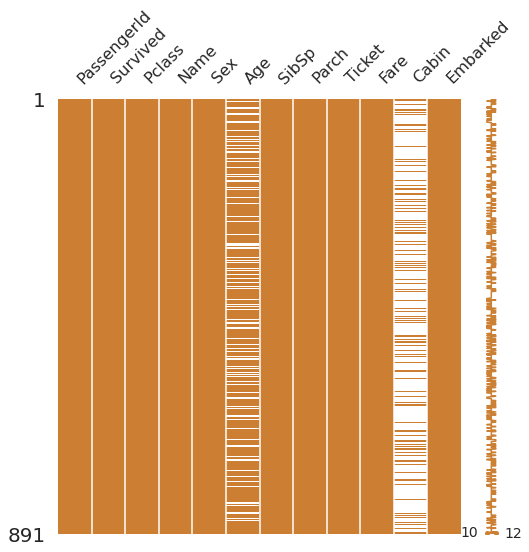

In [9]:
msno.matrix(df=df_train.iloc[:,:], figsize=(8, 8), color=(0.8, 0.5, 0.2))

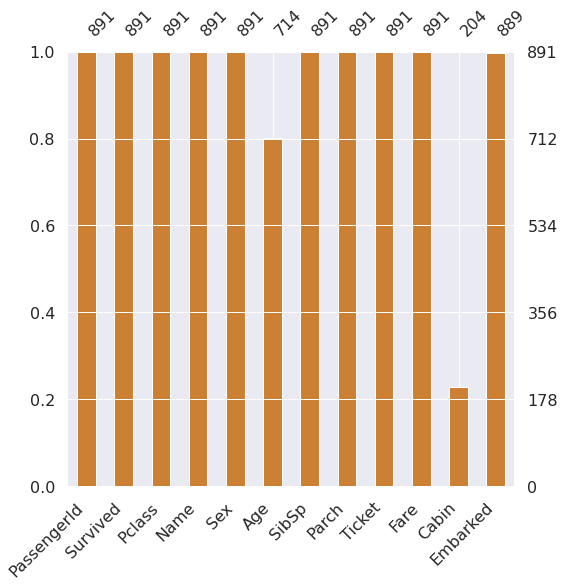

In [10]:
msno.bar(df=df_train.iloc[:,:], figsize=(8,8), color=(0.8, 0.5, 0.2))

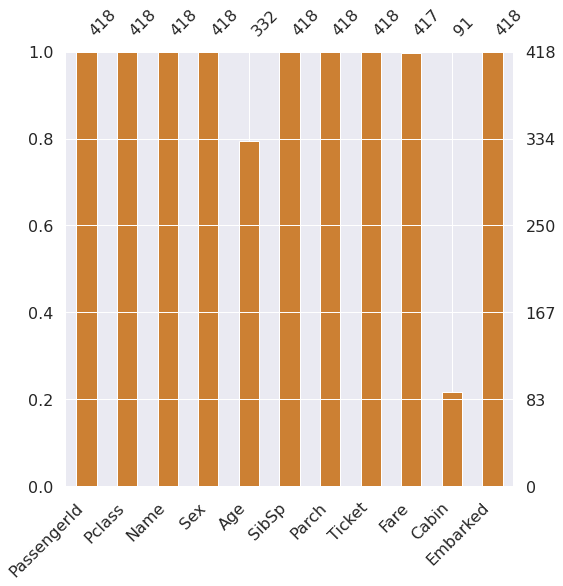

In [11]:
msno.bar(df=df_test.iloc[:,:], figsize=(8,8), color=(0.8, 0.5, 0.2))

> **1.2 Target label 확인**

* target label이 어떤 distribution을 갖고 있는지 확인
* 지금과 같은 binary classification 문제에서, 1과 0의 분포에 따라 모델 평가 방법이 달라질 수 있음

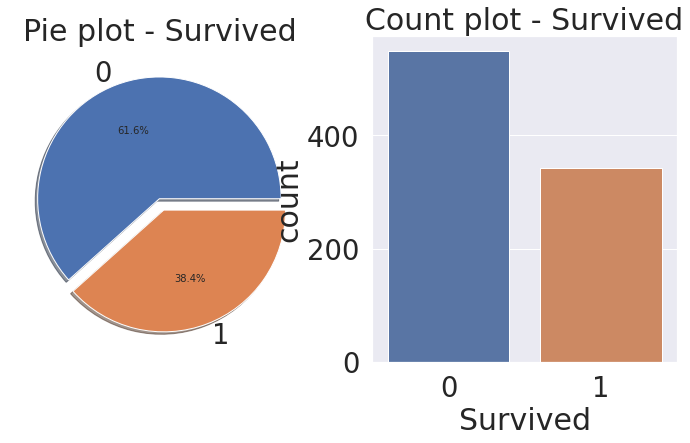

In [12]:
f, ax = plt.subplots(1, 2, figsize=(12, 6))

df_train['Survived'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Survived')
ax[0].set_ylabel('')
sns.countplot('Survived', data = df_train, ax=ax[1])
ax[1].set_title('Count plot - Survived')

plt.show()

* 위의 결과에서 안타깝게도 죽은 사람이 더 많음
* 38.4% 가 생존
* target label의 분포가 제법 균일(balanced).
* 불균일한 경우, 예를 들어 100 중 1이 99, 0이 1개인 경우에는 만약 모델이 모든 것을 1이라고 하더라도 정확도는 99%가 나옴. 0을 찾는 문제라면 이 모델은 원하는 결과를 줄 수 없게 됨. 지금 문제에서는 그렇지 않으니 넘어갈 것

# **2. Exploratory data analysis**

* 본격적으로 데이터 분석 시작
* 데이터가 매우 많기 때문에 이 많은 데이터 안에 숨겨진 사실을 찾기 위해 적절한 시각화 필요

* 시각화 라이브러리 : matplotlib, seaborn, plotly 등

> **2.1 Pclass**

* Pclass : ordinal, 서수형 데이터. 카테고리이면서 순서가 있는 데이터 타입
* 먼저 Pclass에 따른 생존률 차이를 살펴볼 것. 엑셀의 피벗 차트와 유사한 작업을 하게 되는데, pandas dataframe에서는 groupby를 사용하면 쉽게 할 수 있음. 또한 pivot이라는 메소드도 있음
* 'Pclass', 'Survived'를 가지고 온 후, pclass로 묶음. 그 후 각 pclass마다 0, 1이 count가 되는데, 이를 평균 내면 각 pclass 별 생존률이 나옴
* 아래와 같이 count() 하면, 각 class에 몇 명이 있는지 확인할 수 있음. sum()을 하면, 216명 중 생존한 (survived=1) 사람의 총합을 주게 됨.

In [13]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).count()
#각 class에 몇 명이 있는지 count

,Survived
Pclass,
1,216
2,184
3,491


In [14]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).sum()
# 216명 중 생존한(Survived=1) 사람의 총 합

,Survived
Pclass,
1,136
2,87
3,119


* pandas의 crosstab을 사용하면 위의 과정을 좀 더 수월하게 확인 가능

In [15]:
pd.crosstab(df_train['Pclass'], df_train['Survived'], margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


* grouped 객체에 mean()을 하게 되면, 각 클래스 별로 생존률을 얻을 수 있음
* class 1의 경우 다음과 같다  :  80/(80+136) ≈ 0.63

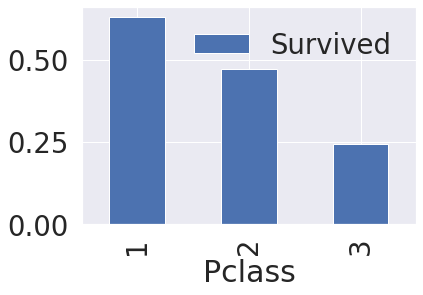

In [16]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar()
# 내림차순 : ascending=False

* Pclass가 좋을수록(1st > 2nd > 3rd) 생존률이 높음
* 좀 더 보기 쉽게 그래프를 그려볼 것.
* seaborn의 countplot을 이용하면 특정 label에 따른 개수 확인 가능

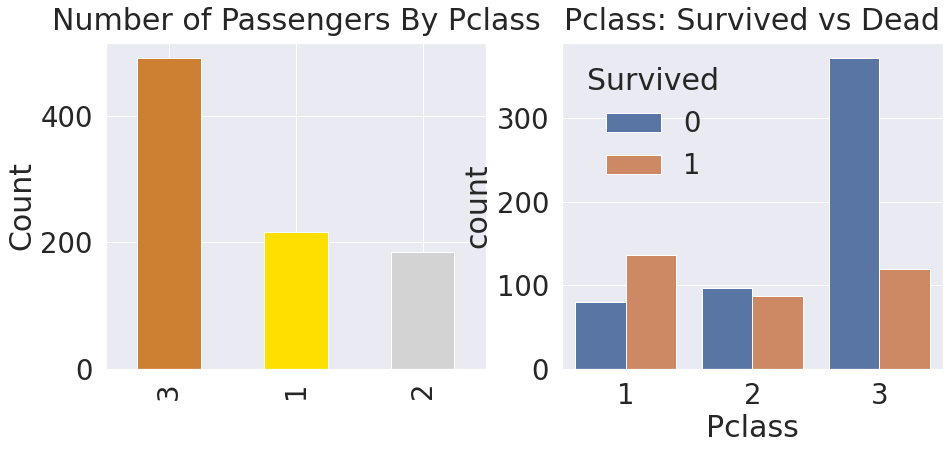

In [17]:
y_position = 1.02

f, ax = plt.subplots(1, 2, figsize=(15, 6))

df_train['Pclass'].value_counts().plot.bar(color=['#CD7F32', '#FFDF00', '#D3D3D3'], ax=ax[0])

ax[0].set_title('Number of Passengers By Pclass', y=y_position)
ax[0].set_ylabel('Count')
sns.countplot('Pclass', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('Pclass: Survived vs Dead', y=y_position)
plt.show()

* 클래스가 높을수록(1st) 생존 확률 높다
* Pclass 1, 2, 3 순서대로 63%, 48%, 25%

* 위의 결과를 통해 생존에 Pclass가 큰 영향을 미친다고 생각해볼 수 있음.
* 따라서 나중에 모델을 세울 떄 이 feature을 사용하는 것이 좋을 것이라 판단.

> **2.2 Sex**

* 이번에는 성별에 따른 생존률 확인
* 마찬가지로 pandas groupby, seaborn countplot 사용하여 시각화

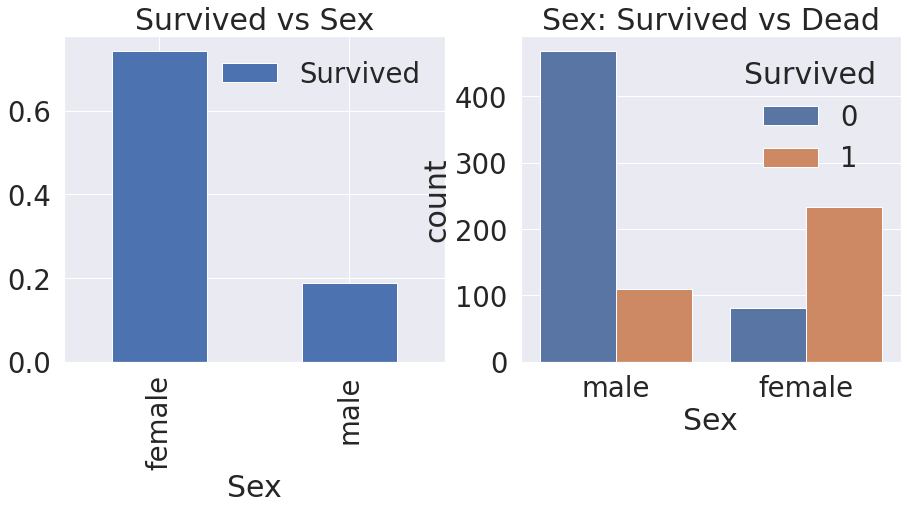

In [18]:
f, ax = plt.subplots(1, 2, figsize=(15, 6))

df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=True).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot('Sex', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('Sex: Survived vs Dead')
plt.show()

* 위에서 보듯, 여성의 생존률이 더 높음

In [19]:
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [20]:
pd.crosstab(df_train['Sex'], df_train['Survived'], margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


* Pclass와 마찬가지로, Sex도 예측 모델에 쓰일 중요한 feature.

> **2.3 Both Sex and Pclass**

* 이번에는 Sex, Pclass 두 가지에 관해 생존이 어떻게 달라지는지 확인
* seaborn의 factorplot을 이용하면 손쉽게 3개의 차원으로 이루어진 그래프 그릴 수 있음

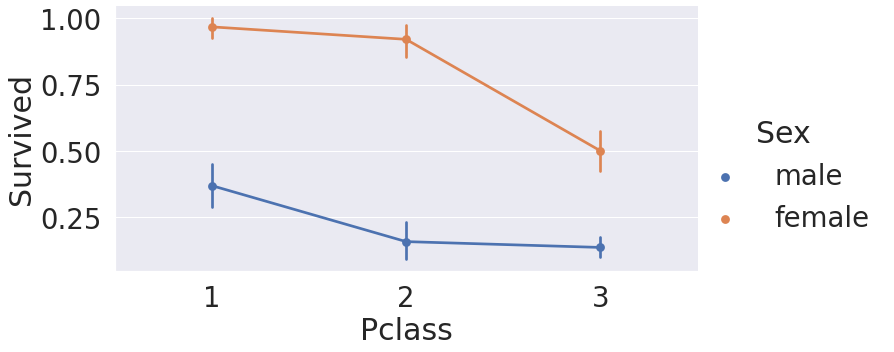

In [21]:
sns.factorplot('Pclass', 'Survived', hue='Sex', data=df_train, size=5, aspect=2.0)

* 모든 클래스에서 female이 살 확률 > male이 살 확률
* 남녀 관계 없이 클래스가 높을수록(1st) 살 확률이 높음
* 위의 그래프는 hue 대신 column으로 하면 아래와 같아짐

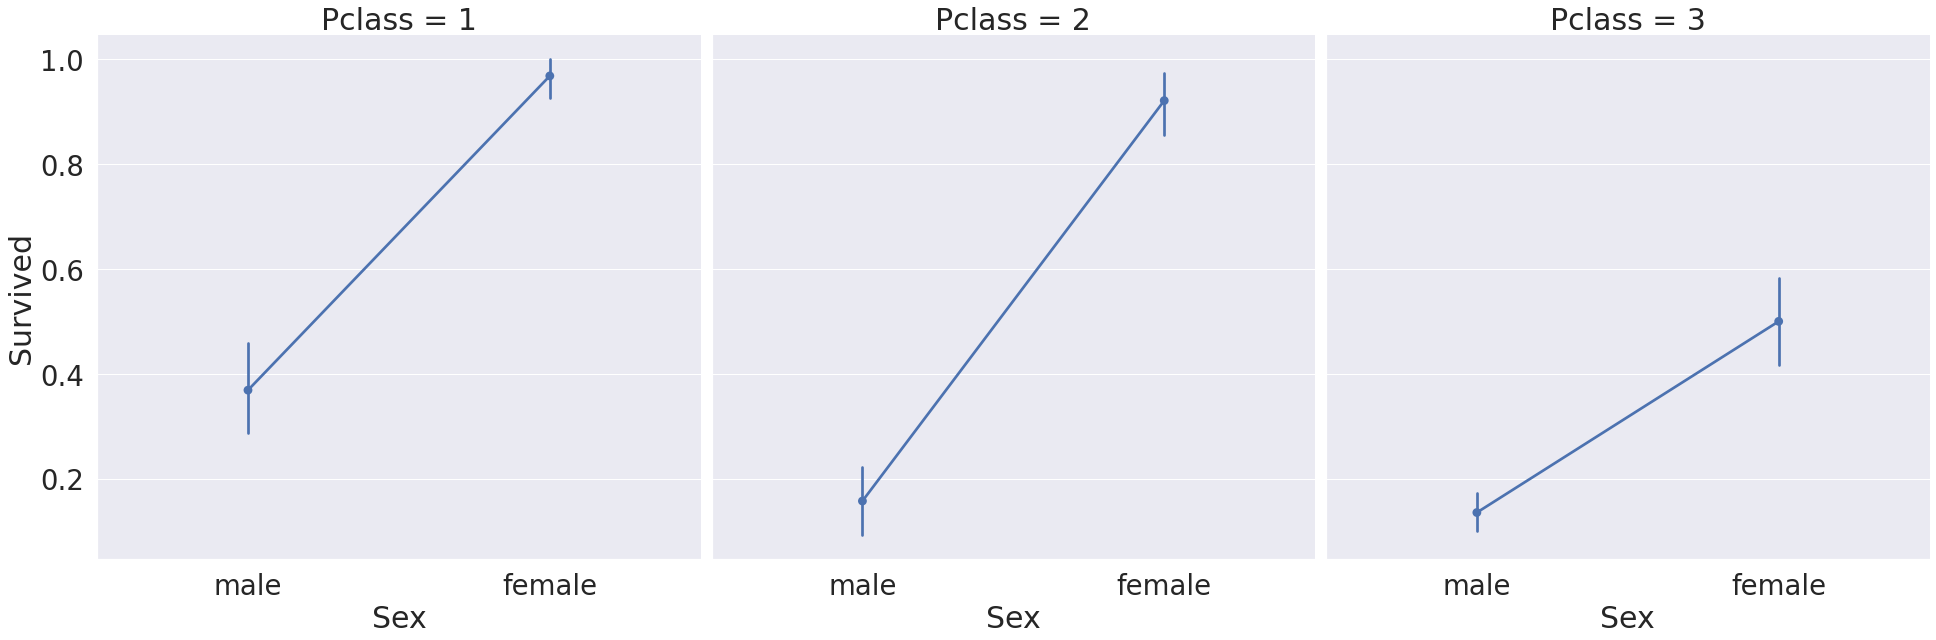

In [22]:
sns.factorplot(x='Sex', y='Survived', col='Pclass',
              data=df_train, satureation=.5,
              size=9, aspect=1)
### satureation=.5  <- 이게 뭘 의미하는건지?

> **2.4 Age**

* 이번에는 Age feature을 살펴보자

In [23]:
print('제일 나이 많은 탑승객 : {:.1f} Years'.format(df_train['Age'].max()))
print('제일 어린 탑승객 : {:.1f} Years'.format(df_train['Age'].min()))
print('탑승객 평균 나이 : {:.1f} Years'.format(df_train['Age'].mean()))

제일 나이 많은 탑승객 : 80.0 Years
제일 어린 탑승객 : 0.4 Years
탑승객 평균 나이 : 29.7 Years


* 생존에 따른 Age의 histogram을 그려보자

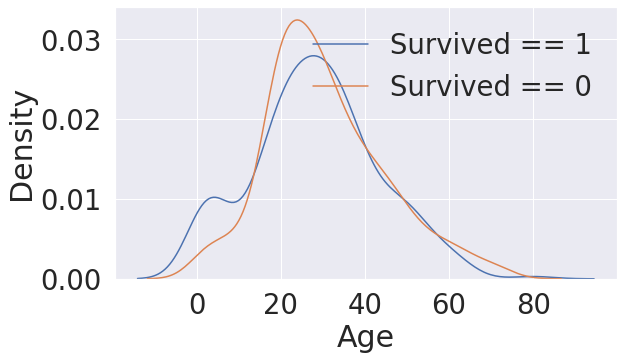

In [24]:
#kdeplot : 데이터의 분포 확인 가능
fig, ax = plt.subplots(1, 1, figsize=(9, 5))

sns.kdeplot(df_train[df_train['Survived']==1]['Age'], ax=ax)
sns.kdeplot(df_train[df_train['Survived']==0]['Age'], ax=ax)

plt.legend(['Survived == 1', 'Survived == 0'])
plt.show()

* 위에서 보듯, 생존자 중 나이가 어린 경우가 많음

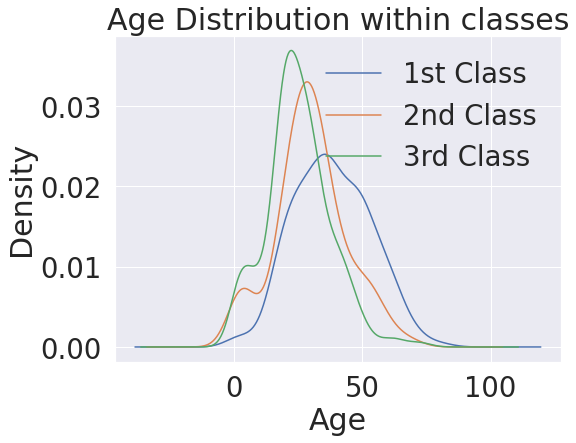

In [25]:
#Age distribution withing classes

plt.figure(figsize=(8,6))

df_train['Age'][df_train['Pclass']==1].plot(kind='kde')
df_train['Age'][df_train['Pclass']==2].plot(kind='kde')
df_train['Age'][df_train['Pclass']==3].plot(kind='kde')

plt.xlabel('Age')
plt.title('Age Distribution within classes')
plt.legend(['1st Class', '2nd Class', '3rd Class'])

* Class가 높을수록 나이 많은 사람의 비중이 커짐
* 나이대가 변하면서 생존률이 어떻게 되는지 확인할 것
* 나이 범위를 점점 넓혀가면서 생존률이 어떻게 변화하는지 확인

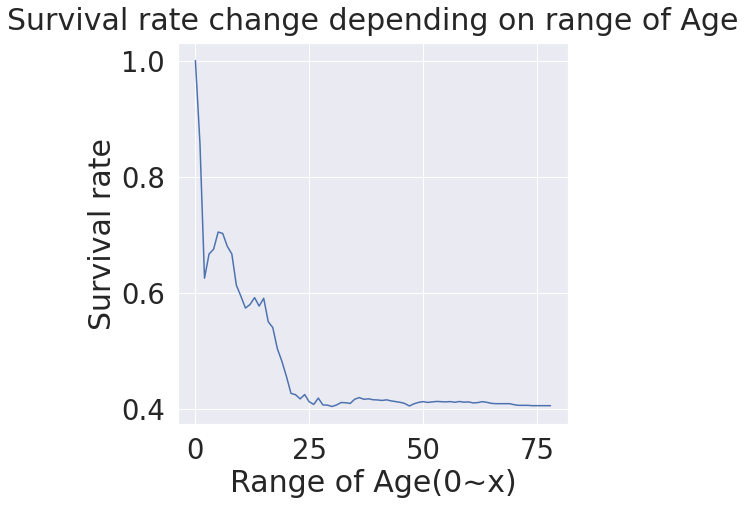

In [26]:
cummulate_survival_ratio = []

for i in range(1, 80):
    cummulate_survival_ratio.append(df_train[df_train['Age'] < i]['Survived'].sum() / len(df_train[df_train['Age'] < i]['Survived']))

plt.figure(figsize=(7, 7))
plt.plot(cummulate_survival_ratio)
plt.title('Survival rate change depending on range of Age', y=1.02)
plt.ylabel('Survival rate')
plt.xlabel('Range of Age(0~x)')
plt.show()

* 위에서 보듯, Age가 어릴수록 생존률이 확실히 높은 것을 확인할 수 있음
* 이를 통해 Age가 중요한 feature로 쓰일 수 있음을 확인

> **2.5 Pclass, Sex, Age**

* 지금까지 본 Sex, Pclass, Age, Survived 모두에 대해 보고 싶음
* 이를 쉽게 그려주는 것이 seaborn의 violinplot
* x축은 우리가 나눠서 보고 싶어하는 case (여기선 Pclass, Sex)
* y축은 보고 싶어하는 distribution(여기선 Age)

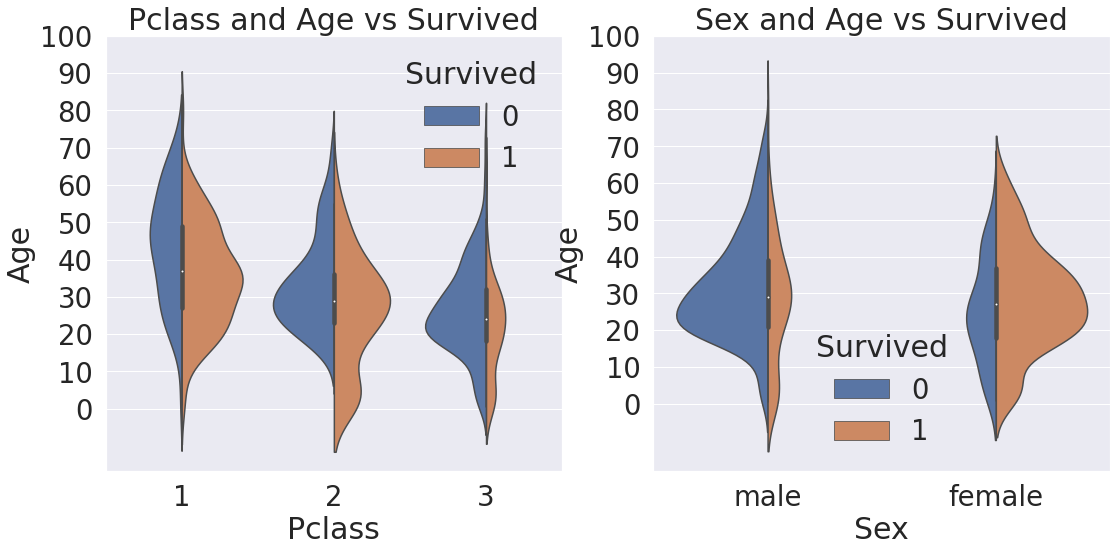

In [27]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot("Pclass","Age", hue="Survived", data=df_train, scale='count', split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))
sns.violinplot("Sex","Age", hue="Survived", data=df_train, scale='count', split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

* 왼쪽 그림은 Pclass별로 Age의 distribution이 어떻게 다른지, 거기에 생존여부에 따라 구분한 그래프
* 오른쪽 그림도 마찬가지 Sex에서 생존에 따른 distribution이 어떻게 다른지 보여주는 그래프
* 생존만 봤을 때, 모든 클래스에서 나이가 어릴 수록 많이 생존
* 오른쪽 그램에서, 여성이 보다 많이 생존한 것을 알 수 있음
* 여성과 아이를 먼저 구한 것을 볼 수 있음

> **2.6 Embarked**

* Embarked : 탑승한 항구
* 위에서와 유사하게 탑승한 곳에 따른 생존률 확인

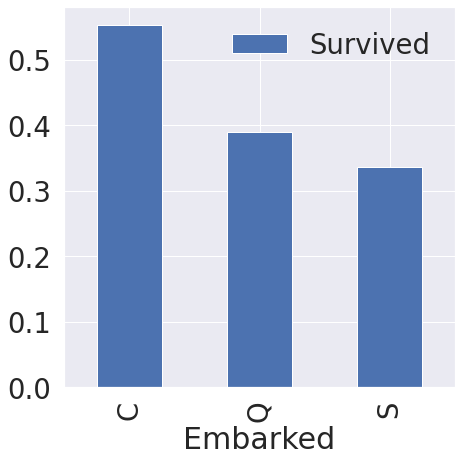

In [28]:
f, ax = plt.subplots(1, 1, figsize=(7, 7))
df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax)


* 위에서 보듯, 약간의 차이는 있지만 전반적으로 생존률은 비슷
* 모델에 얼마나 큰 영향을 미칠지는 의문. 그래도 사용할 것
* 모델을 만들고 나면, 우리가 사용한 feature들이 얼마나 중요한 역할을 했는지 확인할 수 있음 -> 추후 모델 만들고 난 후 살펴볼 것
* 다른 feature로 split하여 한번 살펴보자

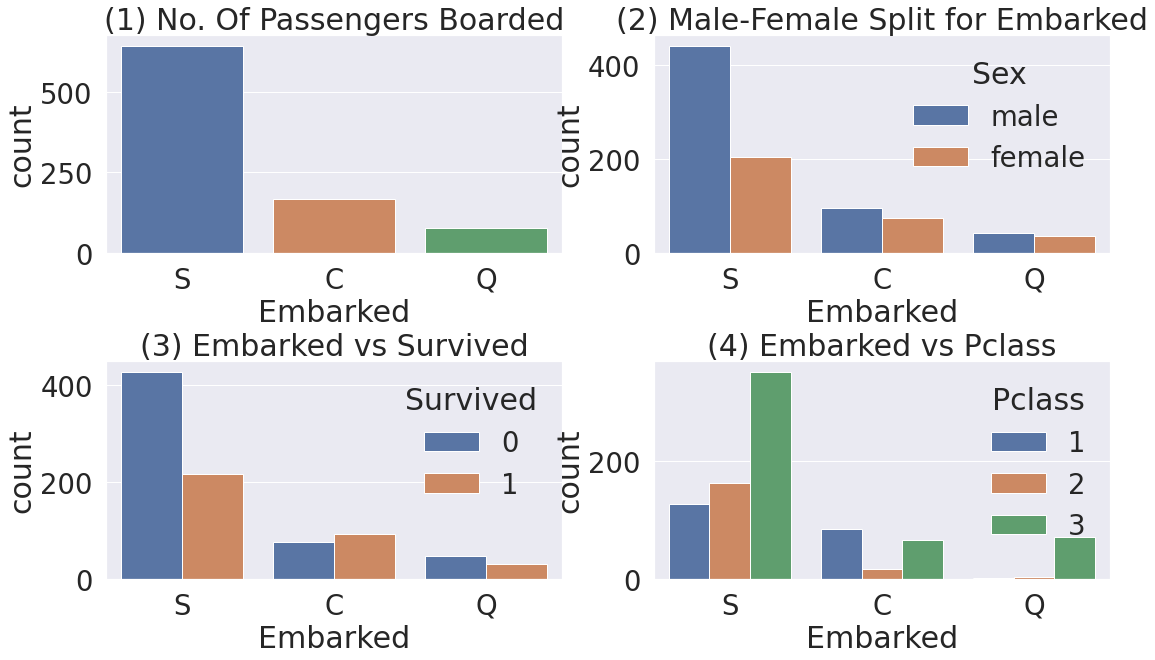

In [29]:
f,ax=plt.subplots(2, 2, figsize=(18,10))
sns.countplot('Embarked', data=df_train, ax=ax[0,0])
ax[0,0].set_title('(1) No. Of Passengers Boarded')
sns.countplot('Embarked', hue='Sex', data=df_train, ax=ax[0,1])
ax[0,1].set_title('(2) Male-Female Split for Embarked')
sns.countplot('Embarked', hue='Survived', data=df_train, ax=ax[1,0])
ax[1,0].set_title('(3) Embarked vs Survived')
sns.countplot('Embarked', hue='Pclass', data=df_train, ax=ax[1,1])
ax[1,1].set_title('(4) Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

* Figure(1) - 전체적으로 S에서 가장 많은 사람이 탑승
* Figure(2) - C와 Q는 남녀 비율 비슷, S에서는 남자가 더 많음
* Figure(3) - S에서 생존확률이 많이 낮음
* Figure(4) - Class로 split 해보니, C가 생존확률이 높은 것은 class가 높은 사람이 많이 타서 그렇다. S에서는 3rd class가 많아서 생존확률 낮음

> **2.7 Family - SibSp(형제 자매) + Parch(부모, 자녀)**

* SibSp와 Parch를 합하면 Family. 
* Family로 합하여 분석

In [30]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 # 자신을 포함해야하니 +1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1 # 자신을 포함해야하니 +1

In [31]:
print("Maximum size of Family: ", df_train['FamilySize'].max())
print("Minimum size of Family: ", df_train['FamilySize'].min())

Maximum size of Family:  11
Minimum size of Family:  1


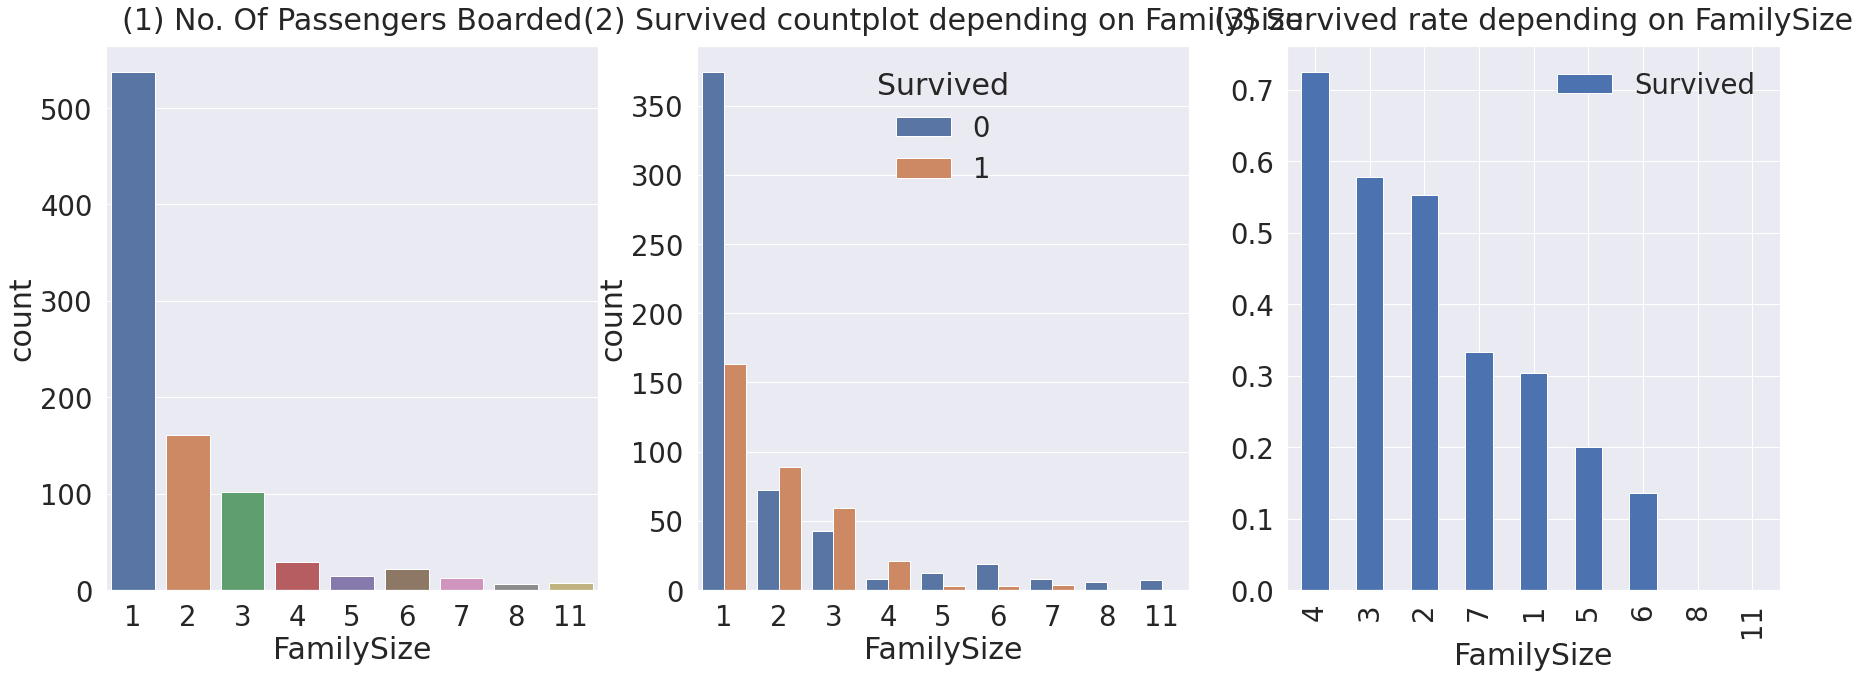

In [32]:
# FamilySize와 생존관계 분석

f,ax=plt.subplots(1, 3, figsize=(30,10))
sns.countplot('FamilySize', data=df_train, ax=ax[0])
ax[0].set_title('(1) No. Of Passengers Boarded', y=1.02)

sns.countplot('FamilySize', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('(2) Survived countplot depending on FamilySize',  y=1.02)

df_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax[2])
ax[2].set_title('(3) Survived rate depending on FamilySize',  y=1.02)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

* Figure(1) - 가족 크기 1~11까지 존재. 대부분 1명이고, 그 다음으로 2, 3, 4명
* Figure(2), (3) - 가족 크기에 따른 생존 비교. 가족이 4명인 경우 생존확률이 가장 높음. 가족수가 많아질수록(5 ~ 8, 11) 생존확률이 낮음. 가족수가 너무 작거나(1) 너무 크면(5, 6, 8, 11) 생존확률이 작음. 3~4명 선에서 생존 확률이 높음

> **2.8 Fare**

* Fare : 탑승요금. contious feature.
* histogram을 그려보자

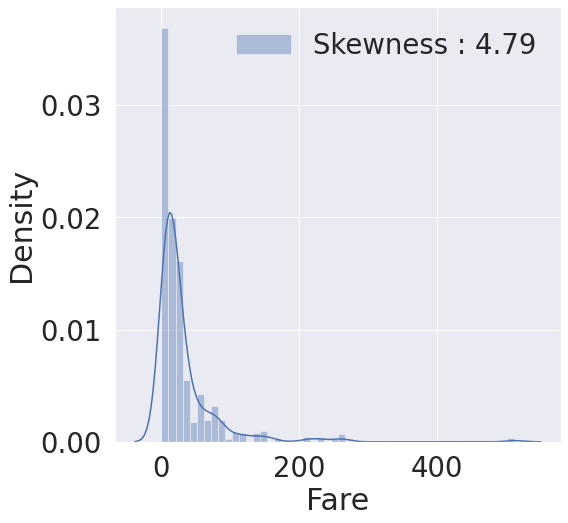

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
g = sns.distplot(df_train['Fare'], color='b', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax=ax)
g = g.legend(loc='best')

* 위에서 보듯, distribution이 매우 비대칭. (high skewness)
* 만일 이대로 모델에 넣어준다면, 모델이 잘못 학습할 가능성 높음
* 몇 개 없는 outlier에 대해 너무 민감하게 반응한다면 실제 예측 시에 좋지 못한 결과를 부를 수 있음

* outlier의 영향을 줄이기 위해 Fare에 log를 취하자
* 여기서 pandas 유용한 기능 사용할 것. dataFrame의 특정 columns에 공통된 작업(함수)를 적용하고 싶으면 아래의 map, 또는 apply 사용하면 됨.
* 우리가 원하는 것 : Fare colums의 데이터 모두를 log 값을 취하는 것. 파이썬의 간단한 lambda 함수를 이용해 간단한 로그를 적용하는 함수를 map에 인수로 넣어주면, Fare columns에 그대로 적용. &매우 유용한 기능이니 꼭 숙지하기&

In [34]:
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean() # testset 에 있는 nan value 를 평균값으로 치환

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

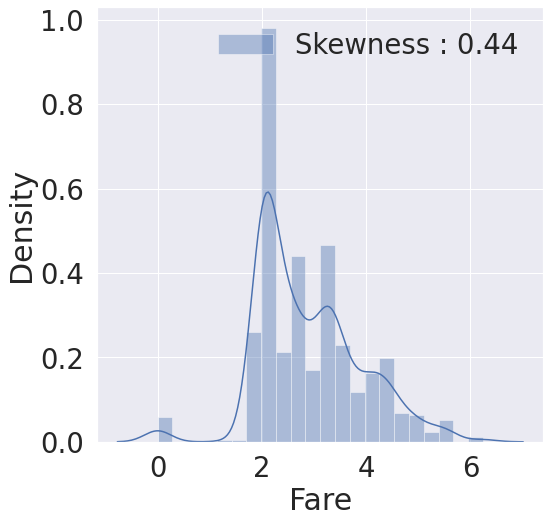

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
g = sns.distplot(df_train['Fare'], color='b', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax=ax)
g = g.legend(loc='best')

* log 를 취하니, 비대칭성이 많이 사라진 것을 볼 수 있음
* 이런 작업을 사용해 모델이 좀 더 좋은 성능을 내도록 할 수 있음
* 사실 방금한 것은 feature engineering 에 들어가는 부분이지만 여기서 작업함
* 모델을 학습시키기 위해, 그리고 그 모델의 성능을 높이기 위해 feature 들에 여러 조작을 가하거나, 새로운 feature를 추가하는 것을 feature engineering 이라고 함. 아래에서 살펴볼 것.

> **2.9 Cabin**

* 이 feature 는 NaN 이 대략 80% 이므로, 생존에 영향을 미칠 중요한 정보를 얻어내기가 쉽지 않음.
* 그러므로 우리가 세우려는 모델에 포함시키지 않도록 할 것

In [36]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,NaN,S,1


> **2.10 Ticket**

* 이 feature에서 NaN 은 없음.
* string data 이므로 우리가 어떤 작업들을 해주어야 실제 모델에 사용할 수 있음. 이를 위해선 아이디어가 필요.

In [37]:
df_train['Ticket'].value_counts()

CA. 2343    7
1601        7
347082      7
347088      6
CA 2144     6
           ..
382649      1
36967       1
345364      1
3101277     1
2664        1
Name: Ticket, Length: 681, dtype: int64

* 위에서 보듯, ticket number는 매우 다양. 여기서 어떤 특징을 이끌어내서 생존과 연결시킬 수 있을까?

# **3. Feature engineering**

* 본격적인 feature engineering 시작

* 가장 먼저, dataset 에 존재하는 null data를 채울 것
* 아무 숫자로 채울 수는 없고, null data 를 포함하는 feature 의 statistics나 다른 아이디어 참고.
* null data 를 어떻게 채우느냐에 따라 모델의 성능이 좌지우지될 수 있기 때문에, 신경써줘야 함.
* Feature engineering 은 실제 모델의 학습에 쓰기 위해 하는 것이므로, train, test 모두 똑같이 적용해야 함.

> **3.1 Fill Null**

**3.1.1 Fill null in Age using title**

* Age : 177개의 null data
* title + statistics 를 사용하여 이를 채워볼 것.
* 영어에서는 Miss, Mrr, Mrs 같은 title이 존재하기 때문에 각 탑승객의 이름에는 꼭 이런 title 이 들어가는 아이디어에서 착안.
* pandas series 에는 data 를 string 으로 바꿔주는 str method, 거기에 정규표현식을 적용하게 해주는 extract method가 있음. 
* 이를 사용하여 title 을 쉽게 추출할 수 있음. title을 Initial column에 저장해볼 것.

In [38]:
df_train['Initial']= df_train.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
    
df_test['Initial']= df_test.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations

In [39]:
#pandas의 crosstab 이용하여 우리가 추출한 Initial과 Sex 간의 count 살펴봄
#Checking the Initials with the Sex
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r') 

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [40]:
#위의 table 참고하여 남녀가 쓰는 initial 구분
#replace 메소드 사용 : 특정 데이터 값을 원하는 값으로 치환
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

In [41]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


* 위에서 보듯, 여성과 관계있는 Miss, Mr, Mrs가 생존률이 높음

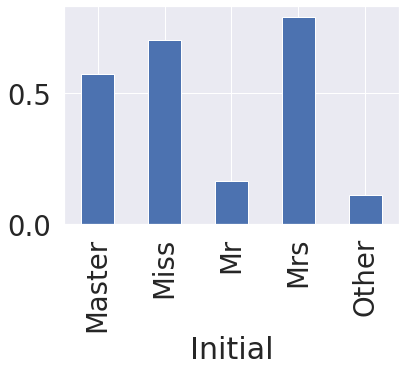

In [42]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

* 본격적으로 Null 을 채워보자. 
* null data 를 채우는 방법 : statistics 를 활용하는 방법, null data 가 없는 데이터를 기반으로 새로운 머신러닝 알고리즘을 만들어 예측해서 채워넣는 방식 등
* 여기서는 statistics 를 활용하는 방법을 사용.
* statistics 는 train data 의 것을 의미. 
* 언제나 test 를 unseen 으로 둔 상태로 놔둬야 하며, train 에서 얻은 statistics 를 기반으로 test 의 null data 를 채워줘야 함.

In [43]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


* Age의 평균을 이용해 Null value 를 채워보자.
* pandas dataframe 을 다룰 때에는 boolean array를 이용해 indexing 하는 방법이 편리.
* 아래 코드 첫줄 : isnull() 이면서 Initial 이 Mr 인 조건을 만족하는 row(탑승객) 의 'Age' 의 값을 33으로 치환한다는 의미.
* **loc + boolean + column**을 사용해 값을 치환하는 방법은 자주 쓰이므로 꼭 익숙해지기 !

In [44]:
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age'] = 46

**3.1.2 Fill Null in Embarked**

In [45]:
print('Embarked has ', sum(df_train['Embarked'].isnull()), ' Null values')

Embarked has  2  Null values


* Embarked : 2개의 Null value
* S 에서 가장 많은 탑승객이 있었으므로, 간단하게 Null 을 S로 채울 것
* dataframe 의 fillna method 를 이용하면 쉽게 채울 수 있음.
* 여기서 inplace=True 로 하면 df_train 에 fillna 를 실제로 적용하게 됨

In [46]:
df_train['Embarked'].fillna('S', inplace=True)

> **3.2 Change Age (continuous to categorical)**

* Age : continuous feature
* 이대로 모델 적용 가능 but Age 를 몇개의 group 으로 나누어 category화 가능.
* continuous 를 categorical 로 바꾸면 자칫 information loss 가 생길 수도 있음. (여기서는 다양한 방법 소개가 목적이니 일단 해보자)
* 여러 가지 방법 : dataframe 의 indexing 방법인 loc 를 사용하여 직접해주기, apply 를 사용해 함수를 넣어주기
* 첫번째로 loc 를 사용한 방법. loc 는 자주쓰게 되므로 그 사용법을 숙지하자
* 나이는 10살 간격

In [47]:
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[70 <= df_train['Age'], 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[70 <= df_test['Age'], 'Age_cat'] = 7

* 두번째로 간단한 함수를 만들어 apply 메소드에 넣어주는 방법
* 훨씬 수월

In [48]:
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7    
    
df_train['Age_cat_2'] = df_train['Age'].apply(category_age)

* 두가지 방법이 잘 적용되었다면, 둘 다 같은 결과를 내야함
* 이를 확인하기 위해 Series 간 boolean 비교 후 all() 메소드를 사용. 
* all() 메소드는 모든 값이 True 면 True, 하나라도 False 가 있으면 False 반환

In [49]:
print('1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 -> ', (df_train['Age_cat'] == df_train['Age_cat_2']).all())

1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 ->  True


* 위에서 보듯 True=. 둘 중 편한 걸 선택하자.
* 이제 중복되는 Age_cat 컬럼과 원래 컬럼 Age 를 제거

In [50]:
df_train.drop(['Age', 'Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

> **3.3 Change Initial, Embarked and Sex (string to numerical)**

* 현재 Initial 은 Mr, Mrs, Miss, Master, Other 총 5개로 나뉨. 
* 카테고리화된 데이터를 모델에 input으로 넣어줄 때 먼저 컴퓨터가 인식할 수 있도록 수치화 작업 필요
* map method를 통해 수치화 작업 가능
* 사전 순서대로 정리하여 mapping 해보자

In [51]:
df_train['Initial'] = df_train['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_test['Initial'] = df_test['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})

* Embarked : C, Q, S로 이루어져 있음. map 을 이용해 바꿔보자
* 앞서, 특정 column 에 어떤 값들이 있는 지 확인해보는 방법.
* 간단히 unique() 메소드를 쓰거나, value_counts() 를 써서 count 까지 보는 방법

In [52]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [53]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

* 위 두 방법을 사용해 Embarked가 S, C, Q 세가지로 이루어진 것을 볼 수 있음.
* 이제 map을 사용해보자

In [54]:
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

* 한번 Null 이 사라졌는지 확인해보자.
* Embarked Column만 가져온 것은 하나의 pandas의 Series 객체라서 isnull() 메소드를 사용해 Series의 값들이 null 인지 아닌지에 대한 boolean 값을 얻을 수 있기 때문. 
* 그리고 이것에 any() 를 사용하여, True 가 단하나라도 있을 시(Null이 한개라도 있을 시) True 를 반환. 
* 우리는 Null 을 S로 다 바꿔주었으므로 False 를 얻게 됨.ㄴ

In [55]:
df_train['Embarked'].isnull().any()

False

In [56]:
#sex : male, female로 나뉘기 때문에 map을 이용해 바꿔보기
df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})
df_test['Sex'] = df_test['Sex'].map({'female': 0, 'male': 1})

* 이제 각 feature 간의 상관관계를 보자. 
* 두 변수간의 Pearson correlation 을 구하면 (-1, 1) 사이의 값을 얻을 수 있음.
* -1로 갈수록 음의 상관관계, 1로 갈수록 양의 상관관계를 의미하며, 0은 상관관계가 없다는 것을 의미


* 여러 feature 를 가지고 있으니 이를 하나의 maxtrix 형태로 보면 편함 = heatmap plot
* dataframe 의 corr() 메소드와 seaborn 을 통해 편하게 그릴 수 있음

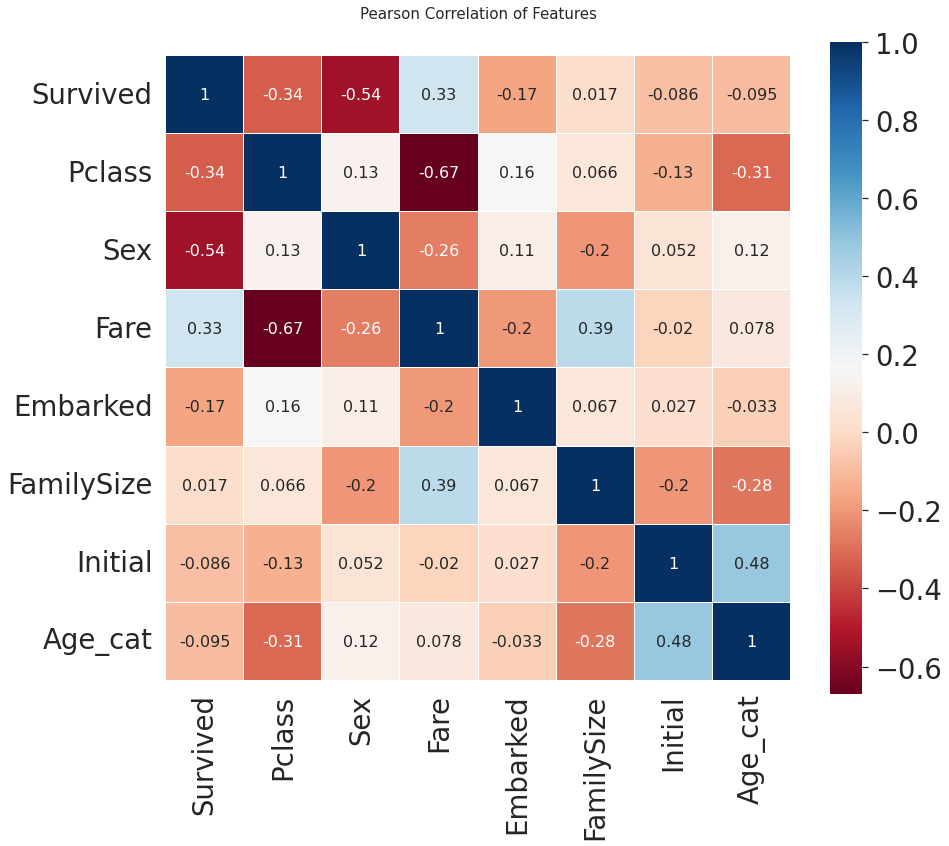

In [57]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']] 

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 16})

del heatmap_data

* EDA에서 살펴봤듯이, Sex 와 Pclass 가 Survived 에 상관관계가 어느 정도 있음.
* 생각보다 fare 와 Embarked 도 상관관계가 있음.
* 또한 서로 강한 상관관계를 가지는 feature들이 없음 => 우리가 모델을 학습시킬 때, 불필요한(redundant, superfluous) feature 가 없다는 것을 의미. 1 또는 -1 의 상관관계를 가진 feature A, B 가 있다면, 우리가 얻을 수 있는 정보는 사실 하나이기 때문.
* 이제 실제로 모델을 학습시키기 앞서서 data preprocessing (전처리)을 진행

> **3.4 One-hot encoding on Initial and Embarked**

* 수치화시킨 카테고리 데이터를 그대로 넣어도 되지만, 모델의 성능을 높이기 위해 one-hot encoding 처리
* 수치화 : 간단히 Master == 0, Miss == 1, Mr == 2, Mrs == 3, Other == 4 로 매핑해주는 것
* One-hot encoding : 위 카테고리를 (0, 1) 로 이루어진 5차원의 벡터로 나타내는 것


*  pandas 의 get_dummies 를 사용하여 쉽게 해결 할 수도 있음.
* 총 5개의 카테고리이므로, one-hot encoding 을 하고 나면 새로운 5개의 column 이 생김
* Initial 을 prefix로 두어서 구분이 쉽게 만들어 줌

In [58]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [59]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0


* 위에서 보듯, 오른쪽에 우리가 만들려고 했던 one-hot encoded columns 가 생성



* Embarked 에도 적용해보자. Initial 때와 마찬가지로 one-hot encoding 을 사용해 표현

In [60]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

* 아주 쉽게 one-hot encoding 을 적용
* sklearn 로 Labelencoder + OneHotencoder 이용해도 one-hot encoding 이 가능
* 나중에 다른 튜토리얼에서 한번 써보자. 여기서는 get_dummies 로 충분히 가능하기 때문에 get_dummies 만으로 끝낼 것
* 가끔 category 가 100개가 넘어가는 경우가 있는데 이때 one-hot encoding을 사용하면 column이 100개가 생겨, 학습시 매우 버거울 경우가 있어 다른 방법 사용하기도 함

> **3.5 Drop columns**

* 이제 필요한 columns만 남기고 다 지우자

In [61]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name',  'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [62]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


In [63]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0
3,3,1,2.159003,1,2,0,0,1,0,0,0,0,1
4,3,0,2.508582,3,2,0,0,0,1,0,0,0,1


* 위에서 보듯, train 의 Survived feature(target class)를 빼면 train, test 둘다 같은 columns 를 가지고 있음

# **4. Building machine learning model and prediction using the trained model**

* 준비가 되었으니, sklearn을 사용해 본격적으로 머신러닝 모델을 돌려보자

In [64]:
#importing all the required ML packages
from sklearn.ensemble import RandomForestClassifier # 유명한 randomforestclassfier. 
from sklearn import metrics # 모델의 평가를 위해서 사용
from sklearn.model_selection import train_test_split # traning set을 쉽게 나눠주는 함수

* Sklearn : feature engineering, preprocessing, 지도 학습 알고리즘, 비지도 학습 알고리즘, 모델 평가, 파이프라인 등 손쉽게 구현 가능

* 타이타닉 문제 : target class(survived) 존재, target class 는 0, 1로 이루어져 있으므로(binary) binary classfication 문제.
* train set 의 survived를 제외한 input 을 가지고 모델을 최적화시켜서 각 샘플(탑승객)의 생존유무를 판단하는 모델을 만들 것.
* 그 후 모델이 학습하지 않았던 test set 을 input 으로 주어서 test set 의 각 샘플(탑승객)의 생존 유무를 예측.

> **4.1 Preparation - Split dataset into train, valid, test set**

* 학습에 쓰일 데이터와, target label(Survived)를 분리. 
* drop 을 사용해 간단히 분리

In [65]:
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

* 보통 train, test 만 사용하기도 하지만, 더 좋은 모델을 만들기 위해 valid set을 따로 만들어 모델 평가
* train_test_split 을 사용하여 쉽게 train 셋을 분리

In [66]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2018)

* 랜덤포레스트 모델 사용
* 랜덤포레스트 : 결정트리기반 모델이며, 여러 결정 트리들을 앙상블한 모델. 
* 랜덤포레스트 파라미터 : n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf 등
* 우선 기본 default 세팅
* 모델 객체를 만들고, fit 메소드로 학습 -> valid set input 을 넣어주어 예측값(X_vld sample(탑승객)의 생존여부)를 얻음

> **4.2 Model generation and prediction**

In [67]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

In [68]:
# 모델 성능
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 268명 중 83.21% 정확도로 생존을 맞춤


> 4.3 Feature importance

* 학습된 모델은 feature importance 를 가짐. -> 이를 통해 지금 만든 모델이 어떤 feature 에 영향을 많이 받았는 지 확인할 수 있음
* pandas series 를 이용하면 쉽게 sorting 을 하여 그래프를 그릴 수 있음

In [69]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

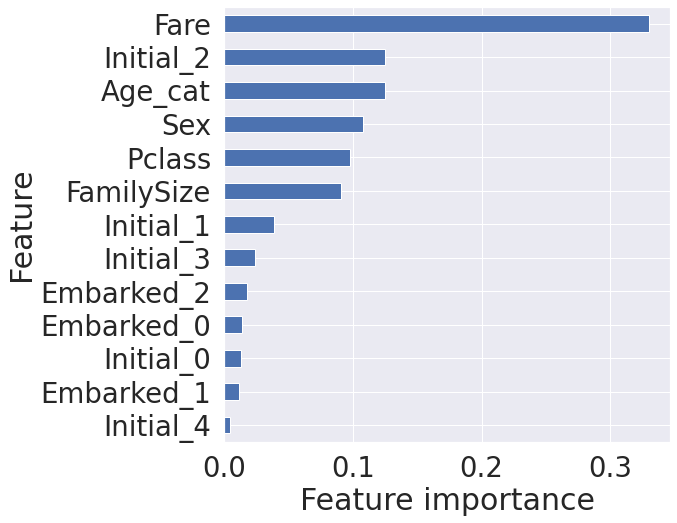

In [70]:
plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

* 위 모델에서는 Fare 가 가장 큰 영향력, 그 뒤로 Initial_2, Age_cat, Pclass가 차례로 영향력 강함

> **4.4 Prediction on Test set**

* 이제 모델이 학습하지 않았던 새로운 테스트셋을 모델에 input으로 주어 생존여부를 예측해보자
* 이 결과는 실제로 submission(제출용), 결과는 leaderboard 에서 확인 가능.

In [74]:
submission = pd.read_csv('/content/drive/MyDrive/kaggle_exercise/titanic/gender_submission.csv')

In [75]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [76]:
# test set에 대하여 예측, 결과를 csv 파일로 저장

prediction = model.predict(X_test)
submission['Survived'] = prediction

In [77]:
submission.to_csv('./submission.csv', index=False)